In [39]:
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
from keras.applications import vgg19
import tensorflow as tf
from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing.image import save_img
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load images and reshape them

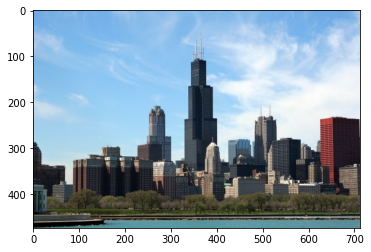

In [3]:
content_img = load_img("chicago.jpg")
plt.imshow(content_img)

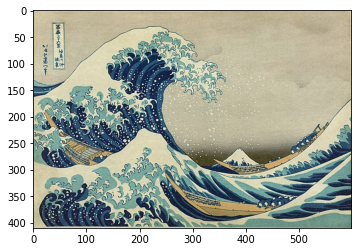

In [4]:
style_img = load_img("great_wave_of_kanagawa.jpg")
plt.imshow(style_img)

In [5]:
width , height = content_img.size
print("Height: " , height)
print("Width: " , width)

Height:  474
Width:  712


In [97]:
#Resize and ration
img_height = 128
img_width = int(width * img_height / height)
print("Desired Height: " , img_height)
print("Desired Width: " , img_width)

Desired Height:  128
Desired Width:  192


## Calculate the three costs

In [98]:
def content_loss(base , generated):
    return K.sum(K.square(generated - base))

In [99]:
def total_variation_loss(x):
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(a+b)

In [100]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [101]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

## Preprocess and deprocess image

In [102]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [103]:
def deprocess_image(x):
    x = x.reshape((img_height, img_width, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Declare constants and placeholders

In [104]:
content_image = K.constant(preprocess_image("chicago.jpg"))
style_image = K.constant(preprocess_image("great_wave_of_kanagawa.jpg"))
print(content_image.shape == style_image.shape)

True


In [105]:
generated_image = combination_image = K.placeholder((1, img_height, img_width, 3))

In [106]:
input_list = K.concatenate([content_image , style_image , generated_image] , axis = 0)

## Create VGG-19 Model

In [107]:
model = vgg19.VGG19(input_tensor=input_list, weights='imagenet', include_top=False)
print(model)

## Display layers in the model

In [108]:
model.layers

In [109]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

## Select content and Style activations

In [110]:
content_layer = 'block5_conv2'

In [111]:
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

## Select the hyperparameters (depends on the aspect ratio goal)

In [112]:
total_variational_weight = 0.0001
style_weight             = 1.
content_weight           = 0.25

## Implement Calculations of cost

In [113]:
total_loss = K.variable(0.0)

In [114]:
activation1 = outputs_dict[content_layer]
content_activation1 = activation1[0,:,:,:]
generated_activation1 = activation1[2,:,:,:]
total_loss = total_loss + (content_weight * content_loss(content_activation1 , generated_activation1))

In [115]:
for layer in style_layers:
    activation2 = outputs_dict[layer]
    style_activation2 = activation2[1,:,:,:]
    generated_activation2 = activation2[2,:,:,:]
    total_loss = total_loss + (style_weight * style_loss(style_activation2 , generated_activation2))

In [116]:
total_loss = total_loss + (total_variational_weight * total_variation_loss(generated_image))

## Create loss and gradient access function

In [117]:
grads = K.gradients(total_loss, generated_image)
fetch_loss_and_grads = K.function([generated_image], [total_loss, grads])

In [118]:
def loss(x):
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    return loss_value

In [119]:
def grads(x):
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    grad_value = outs[1]
    grad_value1 = np.copy(grad_value).flatten().astype('float64')
    return grad_value1

## Define the number of iterations and output path

In [120]:
output_path = "generated_image"
iterations = 20

## Minimize using L-BFGS over pixels of generated image

In [121]:
x = preprocess_image("chicago.jpg")
x = x.flatten()

for i in range(iterations+1):
    print("Iteration : " , i+1)
    x, min_val, info = fmin_l_bfgs_b(loss, x, fprime=grads, maxfun=20)
    print("Loss : " , min_val)
    img = deprocess_image(x.copy())
    fname = output_path + '%d.png' % i
    save_img(fname, img)
    print("Image at iteration %d has been saved" , i+1)

Iteration :  1
Loss :  22544431000.0
Image at iteration %d has been saved 1
Iteration :  2
Loss :  10590422000.0
Image at iteration %d has been saved 2
Iteration :  3
Loss :  6687578000.0
Image at iteration %d has been saved 3
Iteration :  4
Loss :  4971288600.0
Image at iteration %d has been saved 4
Iteration :  5
Loss :  4021973200.0
Image at iteration %d has been saved 5
Iteration :  6
Loss :  3441792500.0
Image at iteration %d has been saved 6
Iteration :  7
Loss :  3055707600.0
Image at iteration %d has been saved 7
Iteration :  8
Loss :  2791774200.0
Image at iteration %d has been saved 8
Iteration :  9
Loss :  2563995600.0
Image at iteration %d has been saved 9
Iteration :  10
Loss :  2393309200.0
Image at iteration %d has been saved 10
Iteration :  11
Loss :  2260767700.0
Image at iteration %d has been saved 11
Iteration :  12
Loss :  2150849000.0
Image at iteration %d has been saved 12
Iteration :  13
Loss :  2064464300.0
Image at iteration %d has been saved 13
Iteration :  14

In [128]:
x = x.reshape((128,192,3))
x = np.clip(x, 0, 255).astype('uint8')
save_img("final.png" , x)

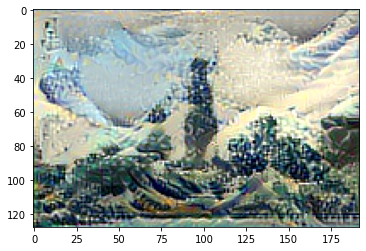

In [125]:
plt.imshow(load_img("generated_image20.png"))